In [2]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn
import seaborn as sns
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
print(torch.cuda.is_available())

torch.cuda.empty_cache()
import warnings
warnings.filterwarnings('ignore')

True


pip install torch pandas scikit-learn transformers tokenizers tqdm matplotlib seaborn
Run this in the terminal first


pd.read_json() is a pandas function that reads data from a JSON file into a dataframe. Here three dataframes such as training set, extended training set and testing set which has been imported from the Datasets library.

(150000, 3)
(300000, 3)
(30000, 2)


<Axes: xlabel='label', ylabel='count'>

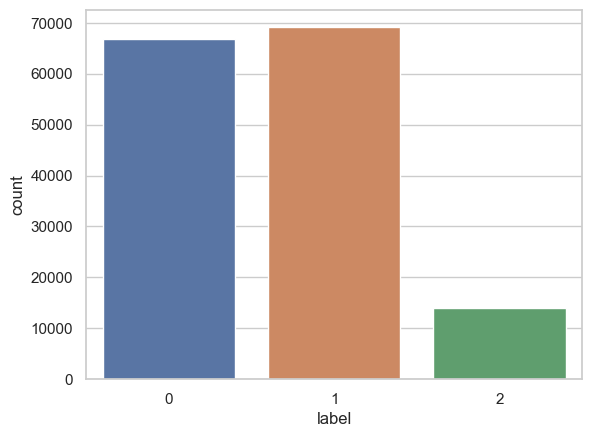

In [7]:
df_train = pd.read_json('../../Datasets/embold_train.json')
df_extended = pd.read_json('../../Datasets/embold_train_extra.json')
df_test = pd.read_json('../../Datasets/embold_test.json')
print(df_train.shape)
print(df_extended.shape)
print(df_test.shape)
# print(df_test)
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)

From the available two training sets has been concatenated using the pd.concat() function from the pandas library. The concatenation has been done vertically (axis=0) and the indexing has been restored by reset_index by dropping the previous index(drop=True).
df_train.head() prints the concatenated training set and shape() method shows the shape of the training dataframe.

In [3]:
df_train = pd.concat([df_train, df_extended], axis=0).reset_index(drop=True)
df_train.head()
df_train.shape

(450000, 3)

The very first line prints the unique values in the 'label' column. sns.set() is used to set aesthetic parameters in seaborn. sns.countplot() creates a count plot of the unique values where the 'label' column is plotted on the x-axis from the df_train data frame. 

Total Counts of label column: 
 label
1    69106
0    66827
2    14067
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

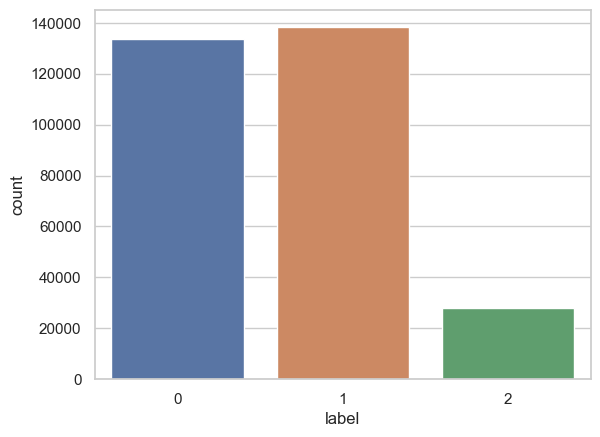

In [16]:
print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_extended)

Setting a random seed for both NumPy and PyTorch. This ensures consistent results across runs. 

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

From the previous output it has been observed that the dataframes are unbalanced and therefore we need to balance it by downsampling. First three dataframes are defined for each labels which are df_train_0, df_train_1, and df_train_2. 
Using the df_train_0.sample the dataframe 0 and 1 are balanced by downsampling where n = df_train_2.shape has been specified. Finally the new dataframes are concatenated and by plotting them using a seaborn plot we can see that the dataframes are balanced now. 


Total Counts of label column: 
 label
0    42201
1    42201
2    42201
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

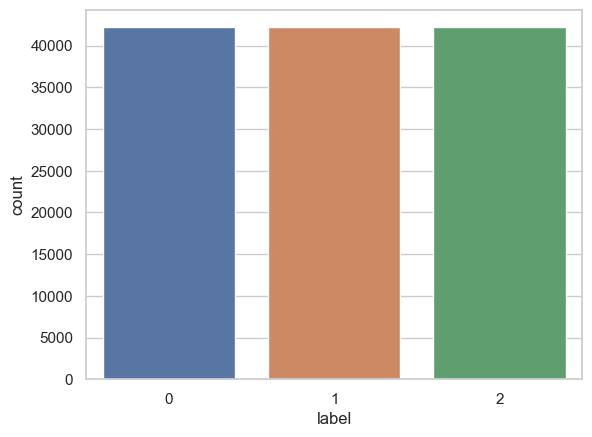

In [5]:
df_train_0 = df_train[df_train['label']==0]
df_train_1 = df_train[df_train['label']==1]
df_train_2 = df_train[df_train['label']==2]
df_train_0 = df_train_0.sample(n=df_train_2.shape[0], random_state=RANDOM_SEED)
df_train_1 = df_train_1.sample(n=df_train_2.shape[0], random_state=RANDOM_SEED)
df_train = pd.concat([df_train_0, df_train_1, df_train_2], axis=0).reset_index(drop=True)
df_train.head()
print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)

In the main dataset we have two columns named 'title' and 'body'. The lambda function takes each row and concatenates the 'title' and 'body' columns with a space in between. The concatenated lines generate a new column named 'text' in the dataframe. 

In [6]:
df_train['text'] = df_train.apply(lambda x: x['title'] + ' ' + x['body'],axis=1)
df_train.head()

,title,body,label,text
0,offset div can not click in safari,when the div which will hold gio globe have of...,0,offset div can not click in safari when the di...
1,textfield should manage the enabled state,the text field component exposes its wrapped t...,0,textfield should manage the enabled state the ...
2,message sanitation for ipaddresses does not ca...,for example:\r \r >>> ip = ' 2a03:f80:ed15:...,0,message sanitation for ipaddresses does not ca...
3,failed after uploading x volume s . error mess...,_from soski...@gmail.com https://code.google...,0,failed after uploading x volume s . error mess...
4,parsing error \ log_file_id\ key in resource/...,change \ \ log_daemon_id\ to \ log_file_id\ ...,0,parsing error \ log_file_id\ key in resource/...


The function clean_text cleans up the lines in the 'text' column by removing the texts within square brackets, urls, html tags, punctuations, newlines and words containing digits. This function returns the cleaned texts. 
The next function remove_stopwords removes the stopwords such as conjuctions, prepositions, punctuations etc then returns the cleaned texts. It uses corpus from nltk which provides the list of stopwords. 

In [7]:

import re
import string
from string import punctuation
from nltk.corpus import stopwords

def clean_text(text):
    text = text.replace("\\r", "")
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def remove_stopwords(git_text):
    remove_punctuation = [ch for ch in git_text if ch not in punctuation]
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_git_text = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    filtered_git_text = " ".join(filtered_git_text)
    return filtered_git_text


The clean_text and remove_stopwords functions are applied to the 'text' column of the dataframe. The cleaned dataframe is saved in the embold_train_cleaned json file. Then the cleaned dataset is loaded into the df_train dataframe.

**Except the loading dataframe every line has been commented out for avoiding the redundant application of the clean_text and remove_stopwords functions and saving the cleaned dataframe. We suggest you to uncomment the following lines before running the code block first time.**

In [8]:
# df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))
# df_train["text"] = df_train["text"].apply(remove_stopwords)
df_train = pd.read_json('../../Datasets/embold_train_cleaned.json', lines=True)
df_train.head()
# df_train.to_json('../../Datasets/embold_train_cleaned.json', orient='records', lines=True)

,title,body,label,text
0,offset div can not click in safari,when the div which will hold gio globe have of...,0,offset div click safari div hold gio globe off...
1,textfield should manage the enabled state,the text field component exposes its wrapped t...,0,textfield manage enabled state text field comp...
2,message sanitation for ipaddresses does not ca...,for example:\r \r >>> ip = ' 2a03:f80:ed15:...,0,message sanitation ipaddresses call generic sa...
3,failed after uploading x volume s . error mess...,_from soski...@gmail.com https://code.google...,0,failed uploading x volume error message except...
4,parsing error \ log_file_id\ key in resource/...,change \ \ log_daemon_id\ to \ log_file_id\ ...,0,parsing error logfileid key resourcedefaultcon...


This is a configuration class for using BERT model. 
1. MAX_LEN: The maximum length of input sequences. Sequences longer than this will be truncated, and sequences shorter than this will be padded.
2. TRAIN_BATCH_SIZE: Batch size used during training.
3. VALID_BATCH_SIZE: Batch size used during validation.
4. EPOCHS: The number of training epochs.
5. BERT_PATH: The path or name of the pre-trained BERT model. In this case, it's set to "bert-base-uncased," which is a commonly used BERT model variant.
6. MODEL_PATH: The path to the pre-trained BERT model weights file.
7. MODEL_PATH: The path to the pre-trained BERT model weights file.
8. TOKENIZER: The tokenizer used to preprocess input text for BERT. It's created using BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True).
9. truncation: A boolean flag indicating whether to truncate sequences which is set to true. 

In [9]:
class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 8
    VALID_BATCH_SIZE = 8
    EPOCHS = 10
    BERT_PATH = "bert-base-uncased"
    MODEL_PATH = "bert-base-uncased/pytorch_model.bin"
    TRAINING_FILE = "../../Datasets/embold_train_cleaned.json"
    TOKENIZER = BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)
    truncation = True

This code block is for training the model locally using the GPU. 'model' loads a pre-trained BERT model using the path specified in the 'config.BERT_PATH' and 'tokenizer' retrieves the pre-trained BERT tokenizer from the configuration. 

In [10]:
device = "cpu"
if(torch.cuda.is_available()):
    device = "cuda"
model = BertModel.from_pretrained(config.BERT_PATH)
tokenizer = config.TOKENIZER
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

The class 'Git_Message' is a dataset class. In this class, 
1. Constructor (__init__):
git_messages: List containing the Git commit messages.
label: List containing corresponding labels for each Git commit message.
tokenizer: The BERT tokenizer to be used for encoding the text.
max_len: The maximum length of the tokenized input sequences.

2. __len__ Method: returns the number of Git commit messages.

3. __getitem__ Method: It takes an index item as input.
Retrieves the Git commit message and its corresponding label at the given index.
Uses the BERT tokenizer (self.tokenizer) to encode the Git commit message.
The tokenization parameters include adding special tokens, setting the maximum length, returning attention masks, and truncating or padding sequences.
This method returns,
'input_ids': Tokenized input sequence.
'attention_mask': Attention mask indicating which tokens are part of the input sequence.
'label': The corresponding label for the input, converted to a PyTorch tensor with data type torch.long.

In [12]:
class Git_Message(Dataset):
    def __init__(self, git_messages, label, tokenizer, max_len):
        self.git_messages = git_messages
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.git_messages)

    def __getitem__(self, item):
        git_messages = str(self.git_messages[item])
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
        git_messages,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=config.truncation,
        )
        return {
         'input_ids': encoding['input_ids'].squeeze(),
         'attention_mask': encoding['attention_mask'].squeeze(),
         'label': torch.tensor(label, dtype=torch.long)
          }

Total Counts of label column: 
 label
2    5000
1    5000
0    5000
Name: count, dtype: int64


((12000, 4), (1500, 4), (1500, 4))

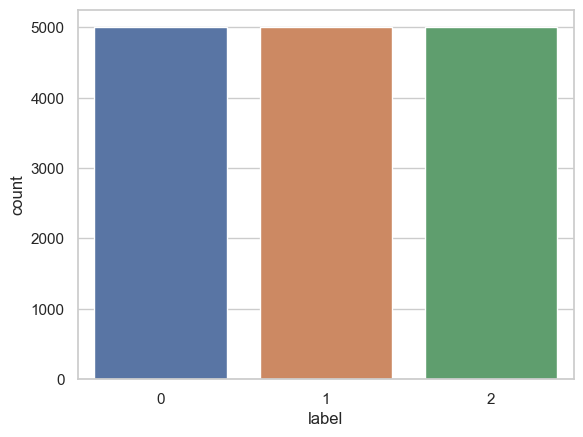

In [13]:
df_class_0 = df_train[df_train['label'] == 0].sample(5000, replace=True)
df_class_1 = df_train[df_train['label'] == 1].sample(5000, replace=True)
df_class_2 = df_train[df_train['label'] == 2].sample(5000, replace=True)

df_train = pd.concat([df_class_0, df_class_1, df_class_2], axis=0).reset_index(drop=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)
training_data , testing_data = model_selection.train_test_split(df_train, test_size=0.2, random_state=RANDOM_SEED)
testing_data, validation_data = model_selection.train_test_split(testing_data, test_size=0.5, random_state=RANDOM_SEED)
training_data.shape, testing_data.shape, validation_data.shape

The function create_data_loader takes four parameters: the input data, a tokenizer object used to tokenize the text data, the maximum length of tokenized text and the batch size for the data loader. Inside the function an instance of the 'Git_Message' is created which tokenizes the data, convert labels and other preprocessing steps. Then a data_loader is returned which returns the converted git_message where num_workers indicates that the data loading will be done in one process. 
Finally three instances of the function for training, testing and validation dataset are created which is then used for training the model. 

In [14]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = Git_Message(git_messages=data.text.to_numpy(),
    label=data.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0)


train_data_loader = create_data_loader(training_data, config.TOKENIZER, config.MAX_LEN, config.TRAIN_BATCH_SIZE)
testing_data_loader = create_data_loader(testing_data, config.TOKENIZER, config.MAX_LEN, config.VALID_BATCH_SIZE)
val_data_loader = create_data_loader(validation_data, config.TOKENIZER, config.MAX_LEN, config.VALID_BATCH_SIZE)


'Bug Predictor' class is a subclass of PyTorch Neural Network modules. 
'__init__' is a constructor of the bug predictor class. It is called when the instance of the class is created and takes two parameters: self and n_classes (the number of classes for the classification task) 
For initializing the base class properly the constructor of the parent class needs to be called using 'super'.
1. 'self.bert_model = BertModel.from_pretrained("bert-base-uncased")': This line creates an instance of the BERT model using the BertModel.from_pretrained which loads the pre-trained model 'bert-based-uncased'.
2. 'self.dropout = nn.Dropout(p=0.0)' : This creates a dropout layer which is a regularization technique which is used in neural networks to prevent overfitting.
3. 'self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)' : This linear layer outputs the number of classes. This will produce the final output of the classification task. 

The 'forward' method specifies how input data should be processed which takes input id of the samples and attention mask which specifies the significant words from the preprocessed samples. This two informations are contained in the the 'outputs' variable. 'outputs[1]' applies the dropout to the pooled output of the BERT model. This method returns the final output of the neural network. 

In [15]:
class BugPredictor(nn.Module):
    
    def __init__(self, n_classes):
        super(BugPredictor, self).__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(p=0.0)
        self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(
        input_ids=input_ids,
        attention_mask = attention_mask
        )
        output = self.dropout(outputs[1])
        return self.out(output)

Here the number of classes in the model is specified in 'class_names'. Then the model is moved to the device 'cpu' or 'cuda'. This step is necessary when working with GPUs which ensures that the model's computations are performed on the specified device. 

In [16]:
class_names = [0, 1, 2]
bug_predictor_model = BugPredictor(len(class_names)).to(device)


1. number of training epochs indicating how many times the dataset will be passed through the neural network during training. 
2. 'optimizer' is used to optimize the parameters, learning rate is set to 1e-5 and no bias correction would not be applied. 
3. 'total_steps' calculates the total number of training steps. This adjusts the learning rate during training.
4. The schedular gradually increases the learning rate for a certain number of warm-up steps and then decreases it linearly. 
5. 'loss_fn' creates an instance of cross-entropy loss function aka log loss which measures the performance of a classification model whose output is a probability value between 0 and 1. The loss function is moved to the specified device for computation. 

In [17]:
EPOCHS = 10

optimizer = AdamW(bug_predictor_model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

'train_model' function takes neural network model, data_loader, loss function, optimizer, computing device, the learning rate scheduler and the total number of examples and trains the model. This function does:
1. Trains the model by calling the 'train()' method. 
2. Initializes an empty list named 'losses' which stores losses for each batch
3. 'correct_predictions' variable to count the number of correct predictions
4. 'total_len' computes the total number of batches in the data loader.
5. In the for loop it iterates through the batches in the data loader. 
6. Moves the input ids, attention mask and target labels to the specified device. 
7. 'outputs' performs a forward pass of the model to obtain predictions for the given batch.
8. 'preds' computes the predicted class labels by taking the argmax along the second dimension of the output. 
9. 'loss' computes the loss using the loss function, model's prediction and target labels. 
10. 'correct_predictions' updates the count of correct predictions by summing the number of correctly classified instances in the batch.
11. Every loss value is added to the list of losses. 
12. 'loss.backward' computes the gradient of the loss with respect to the model parameters.
13. 'optimizer.step()' updates the model parameters using the optimizer.
14. 'scheduler.step()' updates the learning rate using the scheduler.
15. 'optimizer.zero_grad()' clears the gradients calculated during the backward pass for preventing from adding to multiple batches.

The function finally returns the accuracy and average loss for the training dataset. The accuracy is the ratio of correct predictions to the total number of examples, and the average loss is the mean of the losses over all batches.

In [18]:
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    total_len = len(data_loader)
    i=1
    for d in data_loader:
        print("Training Batch: {}/{}".format(i, total_len))
        i+=1
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['label'].to(device)
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double()/n_examples, np.mean(losses)

'eval_model' evaluates a trained model on a validation or test dataset. 
eval() method sets the model to evaluation mode. This function is similar to the train_model() function with some changes following:
1. the batch iteration is done without calculating the gradients during the evaluation using 'with torch.no_grad()'.
2. no optimization, scheduler and no gradients. 
Finally the function returns the accuracy and average loss for the entire evaluation dataset and returns them

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    total_len = len(data_loader)
    i=1
    
    with torch.no_grad():
        for d in data_loader:
            print("Validation Batch: {}/{}".format(i, total_len))
            i+=1
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['label'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds==targets)
            losses.append(loss.item())
    
    return correct_predictions.double()/n_examples, np.mean(losses)

'%%time' is the Jupyter command that measures the execution time of the cell. 
'defaultdict' class from the 'collections' module is used to create dictionaries with default values for each key. 
'history' is used to store training and validation history(accuracy and loss) over epochs.
In each iteration over the number of epochs:
1. training accuracy and training loss is being calculated using the train_model().
2. validation accuracy and validation loss is being calculated using the eval_model() function
3. training accuracy, training loss, validation accuracy and validation loss is appended for the current epoch to the history dictionary. 
4. In the final if statement it checks if the current validation accuracy is higher than the best accuracy so far. If it is higher then saves the model's dictionary to a file named 'best_model.bin' and updates the best accuracy to the current validation accuracy. 

After the loop ends the best model is saved based on the validation accuracy. 



In [20]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('EPOCH {}/{}'.format(epoch+1,EPOCHS))
    print('-' * 10)
  
    train_acc, train_loss = train_model(bug_predictor_model, train_data_loader, loss_fn, optimizer, device, scheduler, len(training_data))

    print('Train loss : {} accuracy : {}'.format(train_loss, train_acc))
    
    val_acc, val_loss = eval_model(bug_predictor_model, val_data_loader, loss_fn, device, len(validation_data))
    
    print('Validation loss : {} accuracy : {}'.format(val_loss, val_acc))
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        print('Saving the best model ...')
        torch.save(bug_predictor_model.state_dict(), 'best_model.bin')
        best_accuracy = val_acc

EPOCH 1/10
----------
Training Batch: 1/1500
Training Batch: 2/1500
Training Batch: 3/1500
Training Batch: 4/1500
Training Batch: 5/1500
Training Batch: 6/1500
Training Batch: 7/1500
Training Batch: 8/1500
Training Batch: 9/1500
Training Batch: 10/1500
Training Batch: 11/1500
Training Batch: 12/1500
Training Batch: 13/1500
Training Batch: 14/1500
Training Batch: 15/1500
Training Batch: 16/1500
Training Batch: 17/1500
Training Batch: 18/1500
Training Batch: 19/1500
Training Batch: 20/1500
Training Batch: 21/1500
Training Batch: 22/1500
Training Batch: 23/1500
Training Batch: 24/1500
Training Batch: 25/1500
Training Batch: 26/1500
Training Batch: 27/1500
Training Batch: 28/1500
Training Batch: 29/1500
Training Batch: 30/1500
Training Batch: 31/1500
Training Batch: 32/1500
Training Batch: 33/1500
Training Batch: 34/1500
Training Batch: 35/1500
Training Batch: 36/1500
Training Batch: 37/1500
Training Batch: 38/1500
Training Batch: 39/1500
Training Batch: 40/1500
Training Batch: 41/1500
Tra

This code loads the best model which was saved in the file 'best_model.bin' previously. 'test_acc' calls the 'eval_model' function to evaluate the loaded model on the testing data. It returns the test accuracy and loss but only the accuracy has been shown in the output. 

In [21]:
bug_predictor_model.load_state_dict(torch.load('best_model.bin'))
test_acc, _ = eval_model(bug_predictor_model, testing_data_loader, loss_fn, device, len(testing_data))
print('Test Accuracy : {}%'.format(test_acc.item()*100))

Validation Batch: 1/188
Validation Batch: 2/188
Validation Batch: 3/188
Validation Batch: 4/188
Validation Batch: 5/188
Validation Batch: 6/188
Validation Batch: 7/188
Validation Batch: 8/188
Validation Batch: 9/188
Validation Batch: 10/188
Validation Batch: 11/188
Validation Batch: 12/188
Validation Batch: 13/188
Validation Batch: 14/188
Validation Batch: 15/188
Validation Batch: 16/188
Validation Batch: 17/188
Validation Batch: 18/188
Validation Batch: 19/188
Validation Batch: 20/188
Validation Batch: 21/188
Validation Batch: 22/188
Validation Batch: 23/188
Validation Batch: 24/188
Validation Batch: 25/188
Validation Batch: 26/188
Validation Batch: 27/188
Validation Batch: 28/188
Validation Batch: 29/188
Validation Batch: 30/188
Validation Batch: 31/188
Validation Batch: 32/188
Validation Batch: 33/188
Validation Batch: 34/188
Validation Batch: 35/188
Validation Batch: 36/188
Validation Batch: 37/188
Validation Batch: 38/188
Validation Batch: 39/188
Validation Batch: 40/188
Validatio

The function 'predict_git_category' takes a git message and a pre trained model, encodes the message and uses the model to predict the category(bug, feature or question) of the message. 
'encoded_message'  uses the tokenizer to encode the input git message by including tokenization and formatting operations such as truncation, padding, and returning tensors in PyTorch format.
'input_ids' and 'attention_mask' extracts the input token IDs and attention mask from the encoded messages and moves it to the specified device.
'output' performs a forward pass using the pre-trained model to obtain the outputs for each class. 
'prediction_idx' determines the predicted class index. 
This returns the predicted class name based on the index from the model's output. 

In [22]:
def predict_git_category(sample_message, model):
    encoded_message = tokenizer.encode_plus(sample_message, max_length=config.MAX_LEN,truncation=True, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')
    input_ids = encoded_message['input_ids'].to(device)
    attention_mask = encoded_message['attention_mask'].to(device)
    
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    _, prediction_idx = torch.max(output, dim=1)
    class_names = ['bug', 'feature', 'question']
      
    return class_names[prediction_idx]

'sample_bug_message' contains the input git message and the 'bug_predictor_model' loads the best model from the bin file. Then the function 'predict_git_category' is called by giving the two parameters and it shows the correct output for the git message issue. 
This output is the purpose of our model training. The training set contains a number of github issues along with the labels. We have trained and evaluated the samples from the git message using many models. Finally with best model we have shown the output of a testing input that gives the correct output for the git message issue. 

In [23]:
sample_bug_message = "my appointment functionality is not working"
bug_predictor_model.load_state_dict(torch.load('best_model.bin'))

print('Sample bug message : ', sample_bug_message)
print('Predicted GitHub Category : ', predict_git_category(sample_bug_message, bug_predictor_model))

Sample bug message :  my appointment functionality is not working
Predicted GitHub Category :  bug


Total Counts of label column: 
 label
2    5000
1    5000
0    5000
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

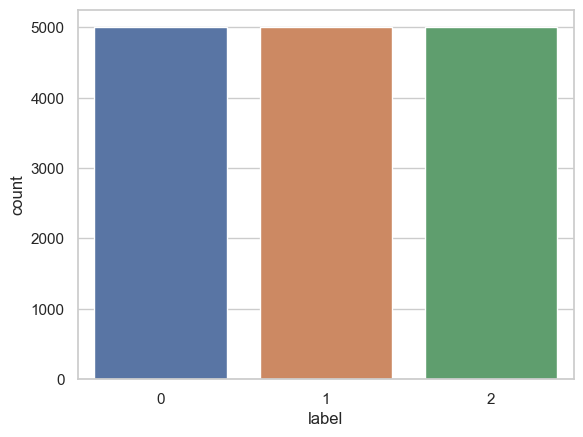

In [24]:
print('Total Counts of label column: \n'.format(),df_train['label'].value_counts())
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x='label', data=df_train)

In this folder the confusion matrix and the ROC and AUC curve has been shown in a separate png file. 